# Calculate ERPs reliability

### Imports

In [1]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression


from scipy.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
dir_path = os.path.dirname(os.path.abspath(""))

In [3]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
random_state = 0

In [4]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600_sonata/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*GNG-(\d+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename, dtype={'Demo_kod': object})
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info, dtype={'Demo_kod': object})
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )      
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    # event_dict = {
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
    #     "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
    #     "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
    #     "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
    #     "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    # }
    
    event_dict = {
        'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10003,
        'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10004,
        'Stimulus/RE*ex*1_n*1_c_2*R': 10005,
        'Stimulus/RE*ex*1_n*2_c_1*R': 10006,
        'Stimulus/RE*ex*2_n*1_c_1*R': 10007,
        'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10008,
        'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10009,
        'Stimulus/RE*ex*2_n*2_c_2*R': 10010,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10003, 10004, 10008, 10009],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10005, 10006, 10007, 10010],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = False
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)

    # reject trials bad at Fz
    idx = reject_log.ch_names.index('Fz')
    mask = (reject_log.labels[:,idx] == 1)
    epochs_ar.drop(mask)
    
    print(f'Reject {len(np.where(mask == True)[0])} trials bad at Fz')    
    
    return epochs_ar

#### Read the data

In [7]:
def change_column_names(data_df):
    columns_dict = {
        "16-Rumination Full Scale": "RRQ", # mean
        "05-DASS-21 Anxiety scale": "DASS-21 Anx", # mean
        "05-DASS-21 Stress scale": "DASS-21 Stress", # mean
        "05-DASS-21 Depression scale": "DASS-21 Dep", # mean
        "04-STAI Trait MEAN": "STAI-T_M", # mean
        "04-STAI STATE 1-2 DIFFERENCE": "STAI-S Diff", # sum
        "number_error" : "uninhibited response", # sum
        "number_inhibited" : "inhibited response", # sum
        "04-STAI Trait SUM": "STAI-T", # sum
        "07-BIS": "BIS", # mean
        "14-Obsessive-Compulsive WASHING": "WASH", # mean
        "14-Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "14-Obsessive-Compulsive HOARDING": "HOARD", # mean
        "14-Obsessive-Compulsive ORDERING": "ORD", # mean
        "14-Obsessive-Compulsive CHECKING": "CHECK", # mean
        "14-Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        "18-Thought Suppression Inventory": "WBSI", # mean
        "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "06-Self-Esteem Scale_SES Rosenberga": "SES", # mean
        "07-BAS Dzialanie": 'BAS_D', # mean
        "07-BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean
        "07-BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean
        "22-Nonforgiveness - Full Scale": 'NONFOR',
        "27-Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "03-SP (Punishment Sensitivity)": 'PUN', # sum
        "03-SR (Reward Sensitivity)": 'REW', # sum
        "15-Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "15-Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "15-Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        "17-Perfectionism CMDA": 'CMDA', # mean
        "17-Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "19-Guilt sensitivity": 'G_SE', # mean
        "31-NFC Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "31-NFC Preferowanie przewidywalności-FULL": 'PRED', # mean
        "32-High standards from Maximization Full Scale" : 'STAND',   # mean
        "Wiek": "Age",
        "Płeć": "Sex",
        "Ręczność": "Handness",    

        #######
        "Rumination Full Scale": "RRQ",
        "DASS-21 Anxiety scale 0-SUM": "DASS-21 Anx", # sum
        "DASS-21 Stress scale 0-SUM": "DASS-21 Stress", # sum
        "DASS-21 Depression scale 0-SUM": "DASS-21 Dep", # sum
        "number_error": "uninhibited response", # sum
        "number_inhibited":  "inhibited response", # sum
        "STAI STATE 1-2 DIFFERENCE": "STAI-S Diff", # sum
        "STAI Trait SUM": "STAI-T", # sum
        "BIS": "BIS", # mean
        "Obsessive-Compulsive WASHING": "WASH", # mean
        "Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "Obsessive-Compulsive HOARDING": "HOARD", # mean
        "Obsessive-Compulsive ORDERING": "ORD", # mean
        "Obsessive-Compulsive CHECKING": "CHECK", # mean
        "Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        "Thought Suppression Inventory": "WBSI", # mean
        "Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "Self-Esteem Scale_SES Rosenberga MEAN": "SES", # mean
        "BAS Dzialanie": 'BAS_D', # mean # drive
        "BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean # fun seeking
        "BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean # responsivness
        "Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "SP (Punishment Sensitivity)": 'PUN', # sum
        "SR (Reward Sensitivity)": 'REW', # sum
        "Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        "Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "Guilt sensitivity": 'G_SE', # mean
        "Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "Preferowanie przewidywalności-FULL": 'PRED', # mean
        "High standards from Maximization Full Scale" : 'STAND',   # mean
    }

    data_df = data_df.rename(columns=columns_dict)
    return data_df

- read Study 1 train data

In [8]:
# %%capture
df_name = "GNG_autoreject_3_5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales_with_rt.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_opus_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    
    # save loaded data into a pickle file
    epochs_train_opus_df.to_pickle("../data/" + epochs_train_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [9]:
epochs_train_opus_df.shape

(110, 188)

In [10]:
epochs_train_opus_df['STAI-T'] = epochs_train_opus_df['STAI-T'].apply(lambda x: x/20)

- read Study 2 train data

In [11]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_stai"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_sonata_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    
    # save loaded data into a pickle file
    epochs_train_sonata_df.to_pickle("../data/" + epochs_train_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [12]:
epochs_train_sonata_df.shape

(150, 110)

Refine some data from questionnaries to reconcile data from two datasets

In [13]:
epochs_train_sonata_df.loc[epochs_train_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [14]:
# normalize DASS-21 subscales scores to mean
epochs_train_sonata_df['DASS-21 Stress'] = epochs_train_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Anx'] = epochs_train_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Dep'] = epochs_train_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [15]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_train_sonata_df['STAI-T'] = epochs_train_sonata_df['STAI-T'].apply(lambda x: x/20)

In [16]:
# fill missing value in STAI-S Diff score
epochs_train_sonata_df.loc[epochs_train_sonata_df['STAI-S Diff'] == 'None', 'STAI-S Diff'] = None
epochs_train_sonata_df['STAI-S Diff'] = np.array(epochs_train_sonata_df['STAI-S Diff'].to_list()).astype(np.float) 

In [17]:
epochs_train_sonata_df['STAI-S Diff'] = epochs_train_sonata_df['STAI-S Diff'].fillna(epochs_train_sonata_df['STAI-S Diff'].mean())

#### Read data for external testing

- read Study 1 test

In [18]:
# %%capture
df_name = "GNG_autoreject_3_5_test_performance"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales_with_rt.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_opus_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    
    # save loaded data into a pickle file
    epochs_test_opus_df.to_pickle("../data/" + epochs_test_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [19]:
epochs_test_opus_df.shape

(45, 164)

In [20]:
epochs_test_opus_df['STAI-T'] = epochs_test_opus_df['STAI-T'].apply(lambda x: x/20)

- read Study 2 test

In [21]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_test_stai"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_sonata_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    
    # save loaded data into a pickle file
    epochs_test_sonata_df.to_pickle("../data/" + epochs_test_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [22]:
epochs_test_sonata_df.shape

(67, 110)

Refine some data from questionnaries to reconcile data from two datasets

In [23]:
epochs_test_sonata_df.loc[epochs_test_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [24]:
# normalize DASS-21 subscales scores to mean
epochs_test_sonata_df['DASS-21 Stress'] = epochs_test_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Anx'] = epochs_test_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Dep'] = epochs_test_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [25]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_test_sonata_df['STAI-T'] = epochs_test_sonata_df['STAI-T'].apply(lambda x: x/20)

In [26]:
# fill missing value in STAI-S Diff score
epochs_test_sonata_df.loc[epochs_test_sonata_df['STAI-S Diff'] == 'None', 'STAI-S Diff'] = None
epochs_test_sonata_df['STAI-S Diff'] = np.array(epochs_test_sonata_df['STAI-S Diff'].to_list()).astype(np.float) 

In [27]:
epochs_test_sonata_df['STAI-S Diff'] = epochs_test_sonata_df['STAI-S Diff'].fillna(epochs_test_sonata_df['STAI-S Diff'].mean())

## Merge dataframes

In [28]:
opus_columns_list = epochs_train_opus_df.columns.to_list()
sonata_columns_list = epochs_train_sonata_df.columns.to_list()

columns = list(set(opus_columns_list) & set(sonata_columns_list))

In [29]:
epochs_train_sonata_df = epochs_train_sonata_df[columns]
epochs_train_opus_df = epochs_train_opus_df[columns]

epochs_test_sonata_df = epochs_test_sonata_df[columns]
epochs_test_opus_df = epochs_test_opus_df[columns]

Create train and test data

In [30]:
epochs_train_df = pd.concat([epochs_train_sonata_df, epochs_train_opus_df], ignore_index=True)
epochs_test_df = pd.concat([epochs_test_sonata_df, epochs_test_opus_df], ignore_index=True)

#### Chose dataset

In [31]:
test = False
dataset = 'test' if test else 'train'

In [32]:
epochs_df = epochs_train_df if not test else epochs_test_df

## Amplitude

### Within subject variability of CRN amplitude

In [44]:
within_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ('extract_epoch_data', ExtractDataEpochs(condition='correct_response')),
            ("mean_amplitude", AverageSignal()),
    ])

    # for each person in dataset
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        id_ = data['id'].to_list()
        personal_X = ern_pipeline.fit_transform(data) * 1000000
        personal_X = personal_X.reshape(-1,1)
        personal_variance = np.std(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_df = pd.concat([within_df, data], ignore_index = True)

In [45]:
within_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,109,8.119907,214
1,Fz,142,8.046895,219
2,Fz,068,7.319774,216
3,Fz,058,6.055905,191
4,Fz,017,10.012175,191


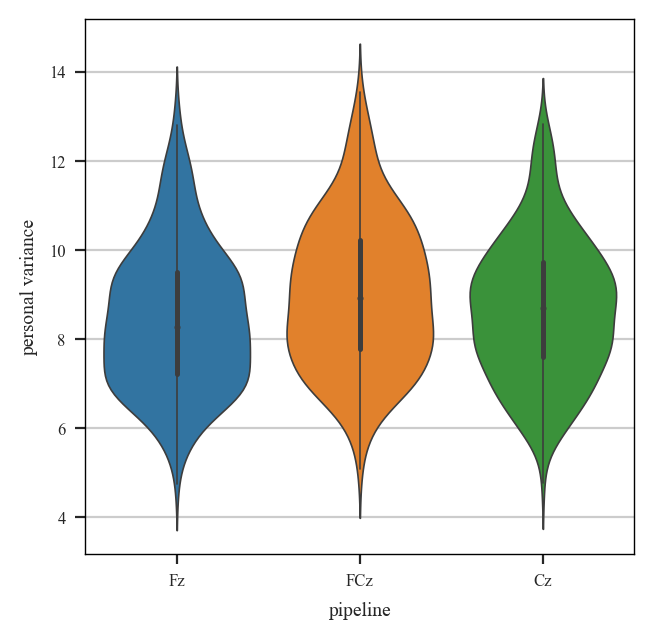

In [56]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [47]:
within_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   260.0  8.659702  1.558025  4.764833  7.594402  8.697423   
FCz                  260.0  9.007880  1.652773  5.074290  7.781364  8.928875   
Fz                   260.0  8.465302  1.586534  4.754758  7.225905  8.272399   

                               num_trials                                \
                75%        max      count        mean        std    min   
pipeline                                                                  
Cz         9.728267  12.834087      260.0  208.396154  16.849114  134.0   
FCz       10.230241  13.543994      260.0  208.396154  16.849114  134.0   
Fz         9.515043  13.074163      260.0  208.396154  16.849114  134.0   

                                      
            25%    50%    75%    max  
pipeline                              
Cz        201.0  214.5  221.0  224.0  
FCz       201.0  214.5  221.0  224.0  
Fz        201.0  214.5  221.0  224.0

In [57]:
within_df.to_csv('../data/consistency_tests/train/crn_amplitude_within.csv')

### Between-subject variability of CRN amplitude

In [48]:
between_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ("average", Evoked(condition='correct_response')),
            ('extract_epoch_data', ExtractData()),
            ("mean_amplitude", AverageSignal()),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy) * 1000000
    X = X.reshape(-1,1)
    variance = np.std(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_df = pd.concat([between_df, data], ignore_index = True)

(260, 1, 27)
(260, 1, 27)
(260, 1, 27)


<AxesSubplot: xlabel='values', ylabel='pipeline'>

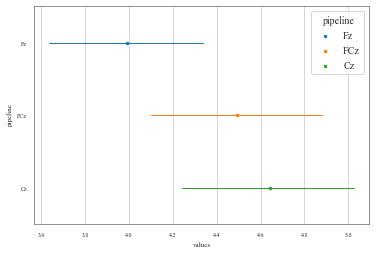

In [49]:
sns.pointplot(
    data = between_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [50]:
between_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          260.0  4.644403  8.898914e-16  4.644403  4.644403  4.644403   
FCz         260.0  4.494379  0.000000e+00  4.494379  4.494379  4.494379   
Fz          260.0  3.988673  8.898914e-16  3.988673  3.988673  3.988673   

                             values                                          \
               75%       max  count      mean       std       min       25%   
pipeline                                                                      
Cz        4.644403  4.644403  260.0  6.216084  4.653360 -9.729309  3.274550   
FCz       4.494379  4.494379  260.0  3.408300  4.503047 -9.043402  0.192371   
Fz        3.988673  3.988673  260.0  1.084649  3.996366 -9.979312 -1.333017   

                                         
               50%       75%        max  
pipeline                                 
Cz        6.278623  8.959271  19.111196  
FCz       3.599143  6.333840  18.757038  
Fz        1.138158  3.470386  12.283547

In [58]:
between_df.to_csv('../data/consistency_tests/train/crn_amplitude_between.csv')

### Internal Consistency of CRN amplitude

In [51]:
consistency_df = pd.DataFrame()

In [52]:
for pipeline in between_df['pipeline'].unique().tolist():
    
    between_std = np.std(np.array(between_df.loc[between_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({'pipeline' : [pipeline],
                'internal_variance' : [internal_consistency],
        })
    
        consistency_df = pd.concat([consistency_df, data], ignore_index=True)

3.9886729528740017
4.494379281452706
4.644402796579374


In [53]:
consistency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   260.0  0.982975  0.006232  0.964256  0.979411  0.983813   
FCz                  260.0  0.980346  0.007385  0.955282  0.975671  0.981629   
Fz                   260.0  0.977980  0.008548  0.947006  0.973016  0.979849   

                              
               75%       max  
pipeline                      
Cz        0.987243  0.995173  
FCz       0.986137  0.994160  
Fz        0.984638  0.993494

In [59]:
consistency_df.to_csv('../data/consistency_tests/train/crn_amplitude_consistency.csv')

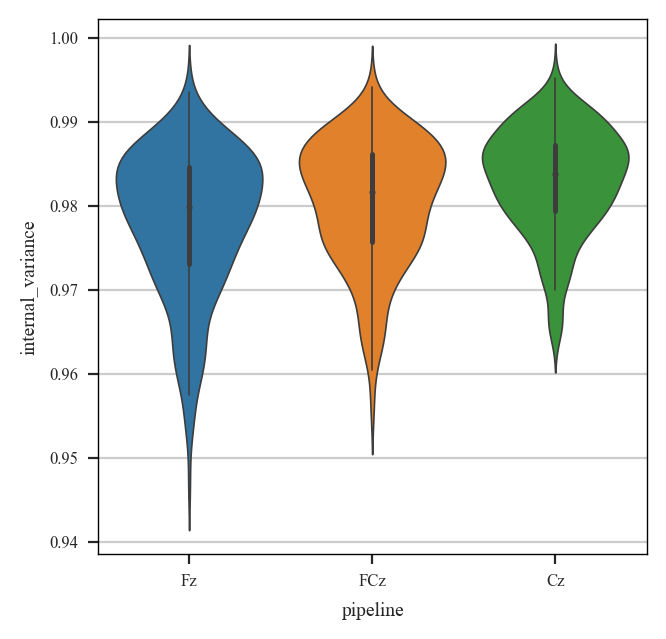

In [54]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

### Within subject variability of ERN amplitude

In [117]:
within_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ('extract_epoch_data', ExtractDataEpochs(condition='error_response')),
            ("mean_amplitude", AverageSignal()),
    ])

    # for each person in dataset
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        id_ = data['id'].to_list()
        personal_X = ern_pipeline.fit_transform(data) * 1000000
        personal_X = personal_X.reshape(-1,1)
        personal_variance = np.std(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_df = pd.concat([within_df, data], ignore_index = True)

In [118]:
within_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,109,6.741451,23
1,Fz,142,7.912416,35
2,Fz,068,9.391849,39
3,Fz,058,4.589446,26
4,Fz,017,8.660873,45


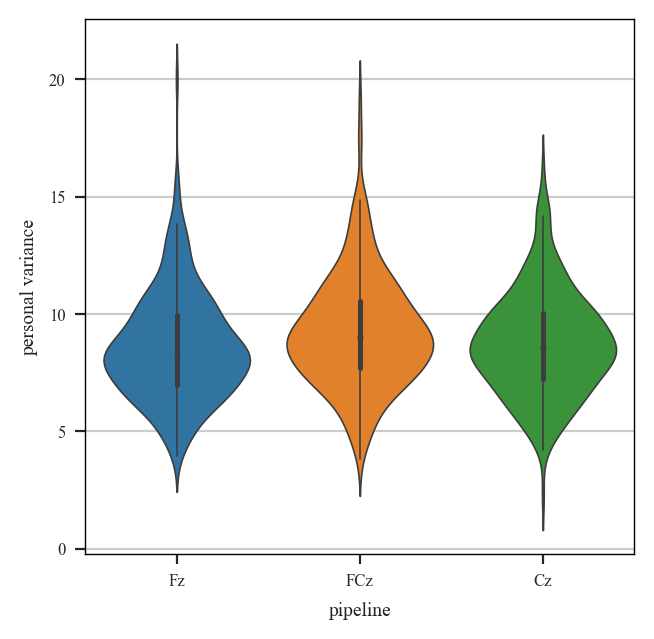

In [119]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [120]:
within_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   260.0  8.761360  2.207125  2.239077  7.247971  8.595118   
FCz                  260.0  9.240412  2.389060  3.818149  7.679341  9.001733   
Fz                   260.0  8.610772  2.289227  3.925616  6.984851  8.280794   

                               num_trials                                   \
                75%        max      count  mean       std  min   25%   50%   
pipeline                                                                     
Cz        10.058271  16.194689      260.0  26.4  14.90438  5.0  15.0  23.0   
FCz       10.570932  19.234427      260.0  26.4  14.90438  5.0  15.0  23.0   
Fz         9.965079  20.014003      260.0  26.4  14.90438  5.0  15.0  23.0   

                       
            75%   max  
pipeline               
Cz        33.25  87.0  
FCz       33.25  87.0  
Fz        33.25  87.0

In [121]:
within_df.to_csv('../data/consistency_tests/train/ern_amplitude_within.csv')

### Between-subject variability of ERN amplitude

In [122]:
between_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ("average", Evoked(condition='error_response')),
            ('extract_epoch_data', ExtractData()),
            ("mean_amplitude", AverageSignal()),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy) * 1000000
    X = X.reshape(-1,1)
    variance = np.std(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_df = pd.concat([between_df, data], ignore_index = True)

(260, 1, 27)
(260, 1, 27)
(260, 1, 27)


<AxesSubplot: xlabel='values', ylabel='pipeline'>

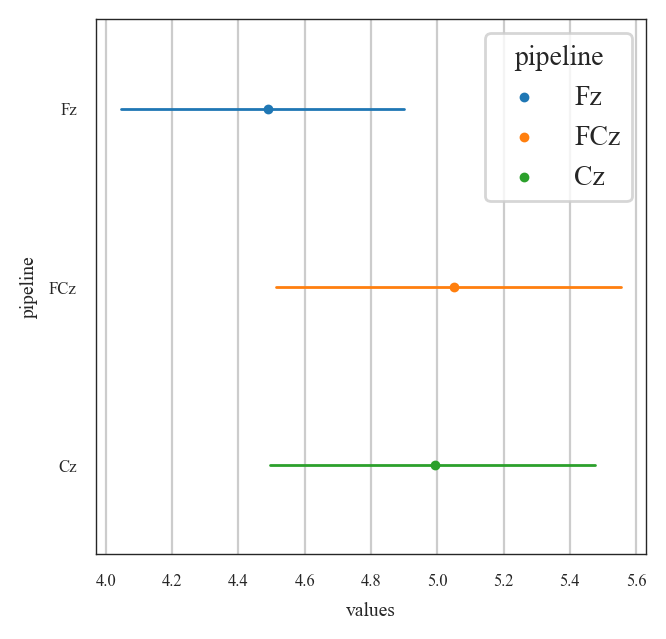

In [123]:
sns.pointplot(
    data = between_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [124]:
between_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          260.0  4.992003  0.000000e+00  4.992003  4.992003  4.992003   
FCz         260.0  5.049829  8.898914e-16  5.049829  5.049829  5.049829   
Fz          260.0  4.488152  0.000000e+00  4.488152  4.488152  4.488152   

                             values                                           \
               75%       max  count      mean       std        min       25%   
pipeline                                                                       
Cz        4.992003  4.992003  260.0 -0.960947  5.001631 -16.679961 -3.686331   
FCz       5.049829  5.049829  260.0 -3.312544  5.059569 -16.758438 -6.333679   
Fz        4.488152  4.488152  260.0 -3.862914  4.496808 -15.804305 -6.228955   

                                         
               50%       75%        max  
pipeline                                 
Cz       -1.121121  2.056849  16.932363  
FCz      -3.063619  0.086378  16.088069  
Fz       -3.960489 -0.771595  13.709576

In [125]:
between_df.to_csv('../data/consistency_tests/train/ern_amplitude_between.csv')

### Internal Consistency of ERN amplitude

In [126]:
consistency_df = pd.DataFrame()

In [127]:
for pipeline in between_df['pipeline'].unique().tolist():
    
    between_std = np.std(np.array(between_df.loc[between_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({'pipeline' : [pipeline],
                'internal_variance' : [internal_consistency],
        })
    
        consistency_df = pd.concat([consistency_df, data], ignore_index=True)

4.488152094614421
5.049829484461446
4.992003203037589


In [128]:
consistency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   260.0  0.864929  0.089736  0.562932  0.822822  0.893661   
FCz                  260.0  0.854905  0.098331  0.471839  0.822642  0.881281   
Fz                   260.0  0.844031  0.104780  0.413158  0.799222  0.874015   

                              
               75%       max  
pipeline                      
Cz        0.930599  0.979072  
FCz       0.926024  0.979238  
Fz        0.921146  0.974088

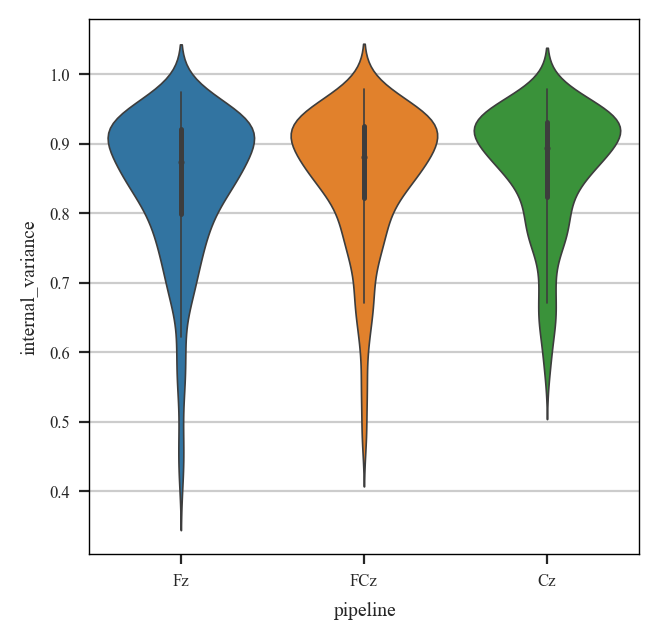

In [129]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [130]:
consistency_df.to_csv('../data/consistency_tests/train/ern_amplitude_consistency.csv')

---

## Latency

In [131]:
class FractionalAreaLatency2(TransformerMixin, BaseEstimator):
    def __init__(self, fraction = 0.5, tmin = 0.0, tmax = 0.5, threshold = 0.0):
        self.fraction=fraction,
        self.tmin=tmin,
        self.tmax=tmax,
        self.threshold=threshold

    def fractional_negative_area_latency(self, signal):
        x = np.linspace(self.tmin[0], self.tmax[0], num=signal.shape[-1])
        y = signal.flatten()
        
        # get only negative part of signal
        y_negative = [abs(y_item) if y_item < self.threshold else 0 for y_item in y]
        
        # calculate area under the signal
        area = abs(simpson(y_negative, x))
        
        if area != 0.0:
            fractional_area = area * self.fraction[0]
        
            # search for latency point (x) which split area according to fraction provided 
            current_area = 0
            fractional_area_index = 0
            i = 2
            while abs(simpson(y_negative[:i], x[:i])) <= fractional_area:
                current_area = abs(simpson(y_negative[:i], x[:i]))
                fractional_area_index = i
                i+=1
            return (fractional_area_index, x[fractional_area_index])    
        else:
            print('No area detected')
            return (np.nan, np.nan) 
         
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if len(X.shape) != 3:
            X=X[0]
        fractional_area_latencies = np.array([self.fractional_negative_area_latency(this_signal)[1] for this_signal in X])
        return fractional_area_latencies

ERN parameters

In [132]:
tmin = -0.05
tmax = 0.2
threshold = 1*1e-6

### Within subject variability of ERN latency

In [133]:
within_latency_df = pd.DataFrame()
rois = [["Fz"], ["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
            ('extract_epoch_data', ExtractDataEpochs(condition='error_response')),
            ("latency", FractionalAreaLatency2(tmin=tmin, tmax=tmax, threshold=threshold)),
    ])

    # for each person in dataset calculate the latency of single trials
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        id_ = data['id'].to_list()
        personal_X = ern_pipeline.fit_transform(data)
        personal_X = personal_X.reshape(-1,1)
        personal_variance = np.nanstd(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_latency_df = pd.concat([within_latency_df, data], ignore_index = True)

No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detected
No area detect

In [134]:
within_latency_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,109,0.048828,23
1,Fz,142,0.023849,35
2,Fz,068,0.028527,39
3,Fz,058,0.038931,26
4,Fz,017,0.043762,45


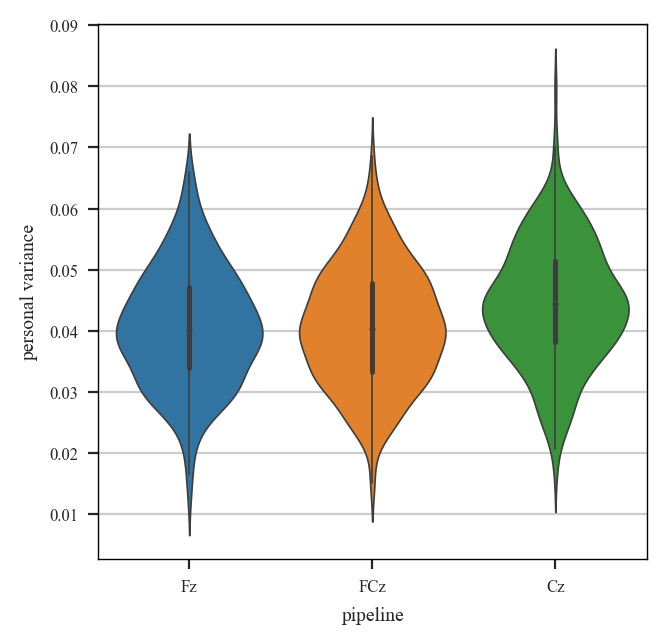

In [135]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_latency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [136]:
within_latency_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   260.0  0.044326  0.009926  0.016922  0.038166  0.044425   
FCz                  260.0  0.040742  0.009585  0.015160  0.033315  0.040396   
Fz                   260.0  0.040582  0.009544  0.012905  0.033934  0.040096   

                             num_trials                                   \
               75%       max      count  mean       std  min   25%   50%   
pipeline                                                                   
Cz        0.051432  0.079609      260.0  26.4  14.90438  5.0  15.0  23.0   
FCz       0.047806  0.068627      260.0  26.4  14.90438  5.0  15.0  23.0   
Fz        0.047255  0.065970      260.0  26.4  14.90438  5.0  15.0  23.0   

                       
            75%   max  
pipeline               
Cz        33.25  87.0  
FCz       33.25  87.0  
Fz        33.25  87.0

In [137]:
within_latency_df.to_csv('../data/consistency_tests/train/ern_latency_within.csv')

### Between-subject variability of ERN latency

In [138]:
between_latency_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
            ("average", Evoked(condition='error_response')),
            ('extract_epoch_data', ExtractData()),
            ("latency", FractionalAreaLatency2(tmin=tmin, tmax=tmax, threshold=threshold)),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy)
    print(X.shape)
    X = X.reshape(-1,1)
    variance = np.nanstd(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_latency_df = pd.concat([between_latency_df, data], ignore_index = True)

(260, 1, 65)
(260,)
(260, 1, 65)
No area detected
(260,)
(260, 1, 65)
No area detected
No area detected
No area detected
No area detected
(260,)


<AxesSubplot: xlabel='values', ylabel='pipeline'>

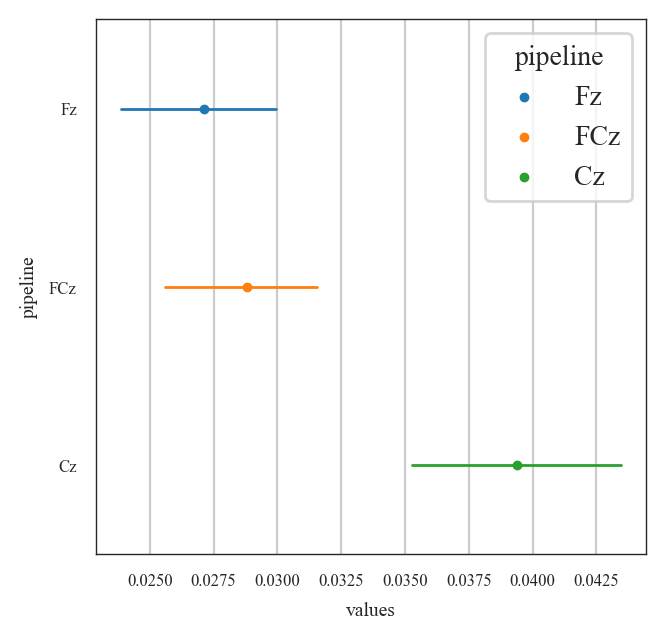

In [139]:
sns.pointplot(
    data = between_latency_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [140]:
between_latency_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          260.0  0.039395  0.000000e+00  0.039395  0.039395  0.039395   
FCz         260.0  0.028792  3.476138e-18  0.028792  0.028792  0.028792   
Fz          260.0  0.027122  0.000000e+00  0.027122  0.027122  0.027122   

                             values                                          \
               75%       max  count      mean       std       min       25%   
pipeline                                                                      
Cz        0.039395  0.039395  256.0  0.038409  0.039472 -0.050000  0.020312   
FCz       0.028792  0.028792  259.0  0.041895  0.028847 -0.050000  0.032031   
Fz        0.027122  0.027122  260.0  0.046214  0.027175 -0.042188  0.032031   

                                        
               50%       75%       max  
pipeline                                
Cz        0.045703  0.067187  0.184375  
FCz       0.043750  0.059375  0.114062  
Fz        0.047656  0.063281  0.121875

In [141]:
between_latency_df.to_csv('../data/consistency_tests/train/ern_latency_between.csv')

### Internal Consistency of ERN latency

In [142]:
consistency_latency_df = pd.DataFrame()

In [143]:
for pipeline in between_latency_df['pipeline'].unique().tolist():
    
    between_std = np.nanstd(np.array(between_latency_df.loc[between_latency_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_latency_df.loc[within_latency_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_latency_df.loc[within_latency_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({'pipeline' : [pipeline],
                'internal_variance' : [internal_consistency],
        })
    
        consistency_latency_df = pd.concat([consistency_latency_df, data], ignore_index=True)

0.02712238027980481
0.028791630398124036
0.03939486015988201


In [144]:
consistency_latency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   260.0  0.940614  0.037034  0.749142  0.929794  0.947900   
FCz                  260.0  0.909654  0.056807  0.654673  0.886069  0.923895   
Fz                   260.0  0.899588  0.063861  0.574133  0.876037  0.916026   

                              
               75%       max  
pipeline                      
Cz        0.966974  0.991061  
FCz       0.949228  0.987068  
Fz        0.943428  0.984420

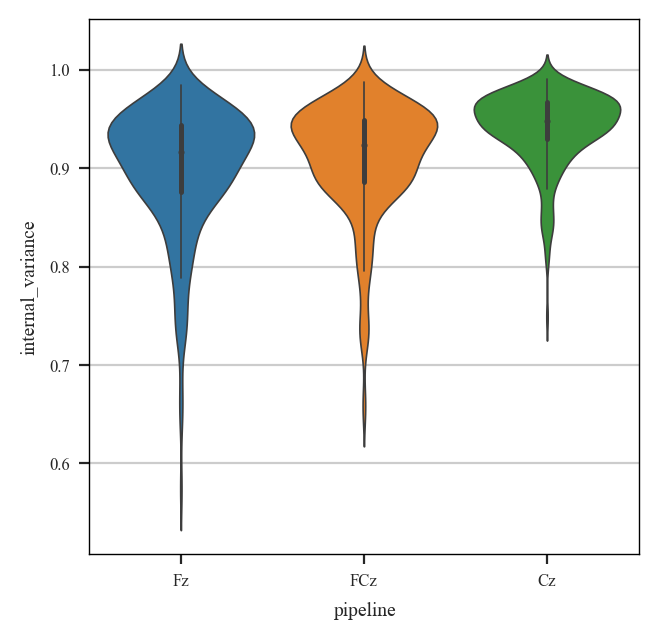

In [145]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_latency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [146]:
consistency_latency_df.to_csv('../data/consistency_tests/train/ern_latency_consistency.csv')

CRN parameters

In [148]:
tmin = -0.05
tmax = 0.2
threshold = 2*1e-6 # threshold at 2 uV

### Within subject variability of CRN latency

In [ ]:
within_latency_df = pd.DataFrame()
rois = [["Fz"], ["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
            ('extract_epoch_data', ExtractDataEpochs(condition='correct_response')),
            ("latency", FractionalAreaLatency2(tmin=tmin, tmax=tmax, threshold=threshold)),
    ])

    # for each person in dataset calculate the latency of single trials
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        id_ = data['id'].to_list()
        personal_X = ern_pipeline.fit_transform(data)
        personal_X = personal_X.reshape(-1,1)
        personal_variance = np.nanstd(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_latency_df = pd.concat([within_latency_df, data], ignore_index = True)

In [150]:
within_latency_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,109,0.056847,214
1,Fz,142,0.046487,219
2,Fz,068,0.034153,216
3,Fz,058,0.066254,191
4,Fz,017,0.057677,191


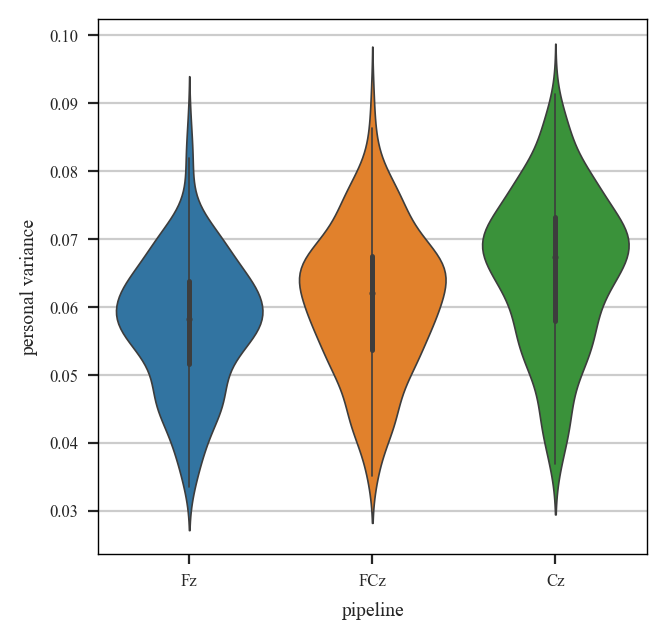

In [151]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_latency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [152]:
within_latency_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   260.0  0.065625  0.011281  0.036886  0.057962  0.067369   
FCz                  260.0  0.060962  0.010515  0.035138  0.053717  0.062064   
Fz                   260.0  0.057527  0.009730  0.033553  0.051635  0.058240   

                             num_trials                                       \
               75%       max      count        mean        std    min    25%   
pipeline                                                                       
Cz        0.073221  0.091332      260.0  208.396154  16.849114  134.0  201.0   
FCz       0.067576  0.091405      260.0  208.396154  16.849114  134.0  201.0   
Fz        0.063765  0.087569      260.0  208.396154  16.849114  134.0  201.0   

                               
            50%    75%    max  
pipeline                       
Cz        214.5  221.0  224.0  
FCz       214.5  221.0  224.0  
Fz        214.5  221.0  224.0

In [153]:
within_latency_df.to_csv('../data/consistency_tests/train/crn_latency_within.csv')

### Between-subject variability of CRN latency

In [154]:
between_latency_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
            ("average", Evoked(condition='correct_response')),
            ('extract_epoch_data', ExtractData()),
            ("latency", FractionalAreaLatency2(tmin=tmin, tmax=tmax, threshold=threshold)),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy)
    print(X.shape)
    X = X.reshape(-1,1)
    variance = np.nanstd(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_latency_df = pd.concat([between_latency_df, data], ignore_index = True)

(260, 1, 65)
(260,)
(260, 1, 65)
(260,)
(260, 1, 65)
(260,)


<AxesSubplot: xlabel='values', ylabel='pipeline'>

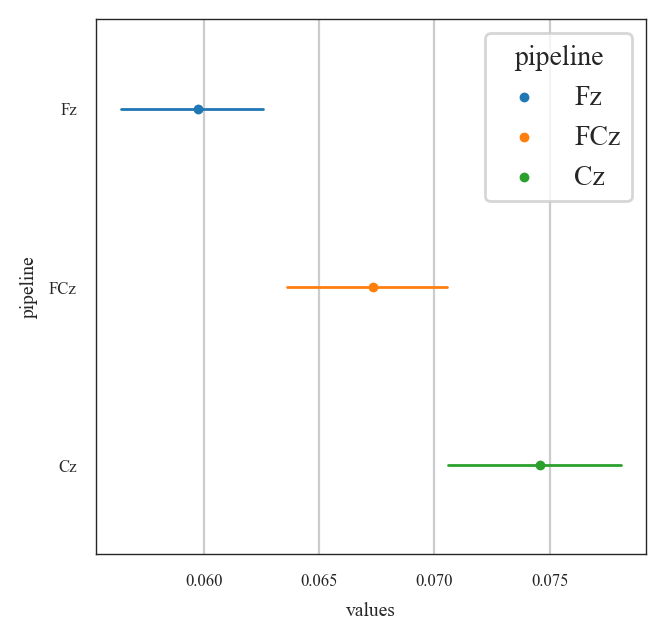

In [155]:
sns.pointplot(
    data = between_latency_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [156]:
between_latency_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          260.0  0.074595  1.390455e-17  0.074595  0.074595  0.074595   
FCz         260.0  0.067343  0.000000e+00  0.067343  0.067343  0.067343   
Fz          260.0  0.059748  6.952277e-18  0.059748  0.059748  0.059748   

                             values                                      \
               75%       max  count      mean       std   min       25%   
pipeline                                                                  
Cz        0.074595  0.074595  260.0  0.031761  0.074739 -0.05 -0.030469   
FCz       0.067343  0.067343  260.0  0.046920  0.067473 -0.05 -0.010938   
Fz        0.059748  0.059748  260.0  0.068690  0.059863 -0.05  0.016406   

                                        
               50%       75%       max  
pipeline                                
Cz       -0.007031  0.110156  0.172656  
FCz       0.028125  0.114062  0.184375  
Fz        0.069141  0.121875  0.184375

In [157]:
between_latency_df.to_csv('../data/consistency_tests/train/crn_latency_between.csv')

### Internal Consistency of CRN latency

In [163]:
consistency_latency_df = pd.DataFrame()

In [164]:
for pipeline in between_latency_df['pipeline'].unique().tolist():
    
    between_std = np.nanstd(np.array(between_latency_df.loc[between_latency_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_latency_df.loc[within_latency_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_latency_df.loc[within_latency_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({'pipeline' : [pipeline],
                'internal_variance' : [internal_consistency],
        })
    
        consistency_latency_df = pd.concat([consistency_latency_df, data], ignore_index=True)

0.05974801504832033
0.06734339678803207
0.0745952753956391


In [165]:
consistency_latency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   260.0  0.996173  0.001261  0.992615  0.995306  0.996125   
FCz                  260.0  0.995954  0.001351  0.991543  0.995168  0.995945   
Fz                   260.0  0.995432  0.001490  0.990153  0.994562  0.995403   

                              
               75%       max  
pipeline                      
Cz        0.997085  0.998873  
FCz       0.996922  0.998700  
Fz        0.996446  0.998549

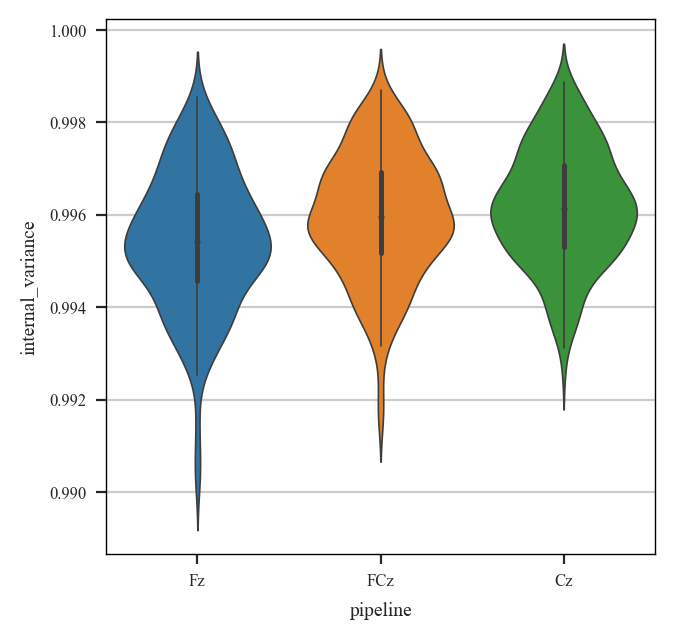

In [161]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_latency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [162]:
consistency_latency_df.to_csv('../data/consistency_tests/train/crn_latency_consistency.csv')